In [1]:
### import libraries we will be using

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
# https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set(
    style='ticks', 
    context='talk', 
    font_scale=0.8, 
    rc={'figure.figsize': (4,4)}
)



from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

## set a random seed for reproducibility
np.random.seed(234)

import warnings
warnings.simplefilter("ignore")

In [2]:
## read in our data

traindemo = pd.read_csv('traindemographics.csv')
trainperf = pd.read_csv('trainperf.csv')
trainprev = pd.read_csv('trainprevloans.csv')
testdemo = pd.read_csv('testdemographics.csv')
testperf = pd.read_csv('testperf.csv')
testprev = pd.read_csv('testprevloans.csv')

In [3]:
## merge our data on customerid and referredby using a left join

def merge_data(data1, data2, data3):
    data = pd.merge(data1, data2, on=['customerid','referredby'], how='left')
    data = pd.merge(data, data3, on='customerid', how='left')
    
    ## The train and test data have duplicate rows. Sort the dataframe on loannumber_y. Drop the duplicates 
    ## Reset the index of the dataframe and return the dataframe
    
    data = data.sort_values('loannumber_y',ascending=False).drop_duplicates('customerid').sort_index().reset_index(drop=True)
    return data

In [4]:
train = merge_data(trainperf, trainprev, traindemo)
test = merge_data(testperf, testprev, testdemo)

In [5]:
train.head(2)

,customerid,systemloanid_x,loannumber_x,approveddate_x,creationdate_x,loanamount_x,totaldue_x,termdays_x,referredby,good_bad_flag,...,firstduedate,firstrepaiddate,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good,...,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good,...,NaN,NaN,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,"DUGBE,IBADAN",Permanent,Graduate


In [6]:
train.head(2).T

,0,1
customerid,8a2a81a74ce8c05d014cfb32a0da1049,8a85886e54beabf90154c0a29ae757c0
systemloanid_x,301994762,301965204
loannumber_x,12,2
approveddate_x,2017-07-25 08:22:56.000000,2017-07-05 17:04:41.000000
creationdate_x,2017-07-25 07:22:47.000000,2017-07-05 16:04:18.000000
loanamount_x,30000.0,15000.0
totaldue_x,34500.0,17250.0
termdays_x,30,30
referredby,NaN,NaN
good_bad_flag,Good,Good


## EXPLORATORY DATA ANALYSIS

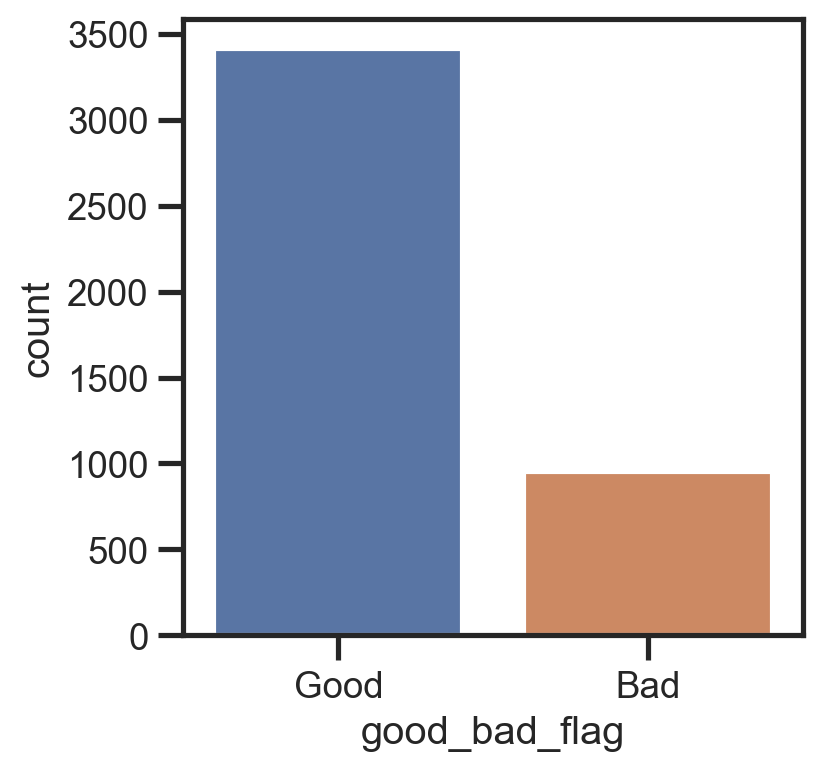

In [7]:
sns.countplot(x="good_bad_flag", data=train);

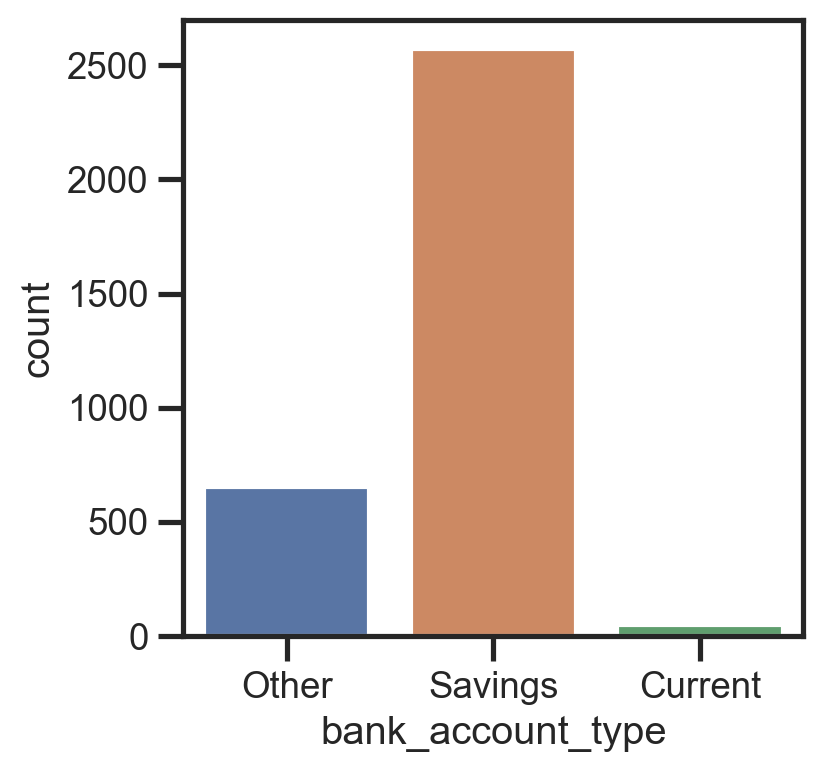

In [8]:
sns.countplot(x="bank_account_type", data=train);

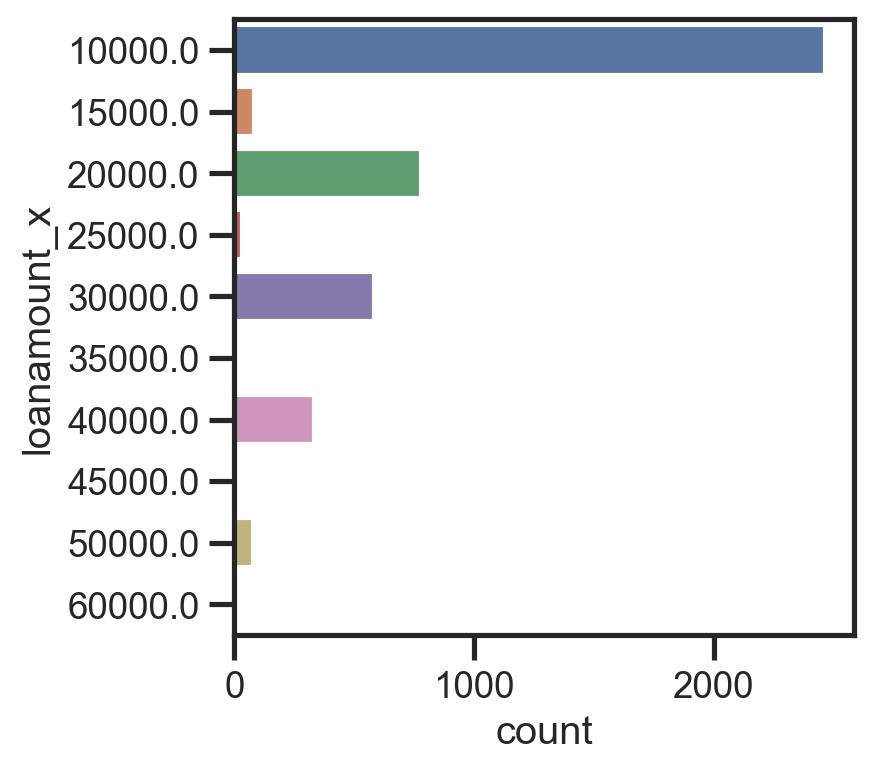

In [9]:
sns.countplot(y="loanamount_x", data=train);

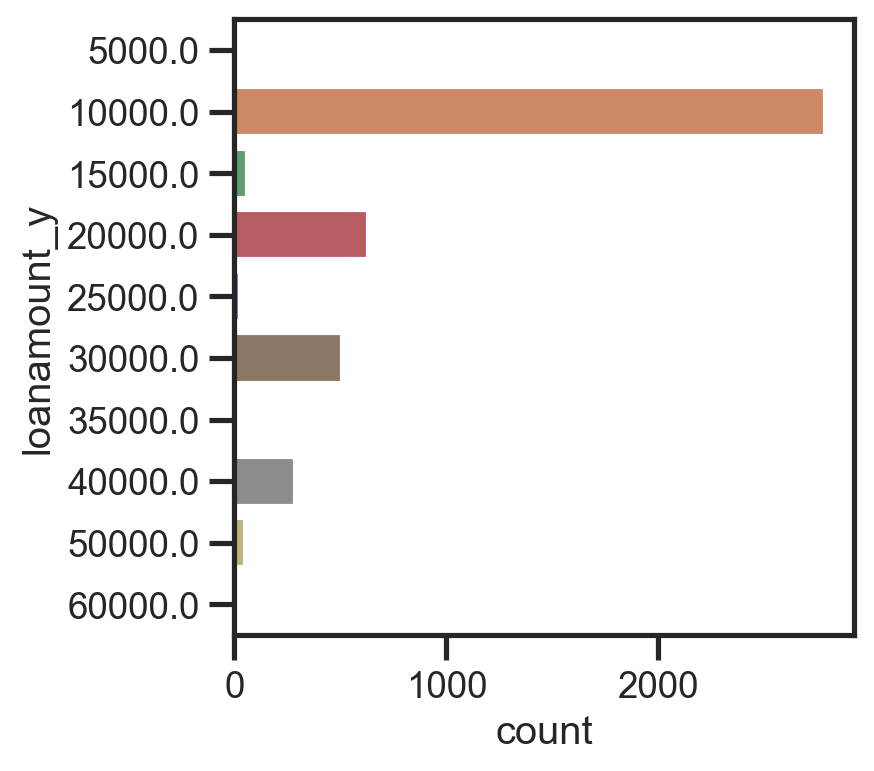

In [10]:
sns.countplot(y="loanamount_y", data=train);

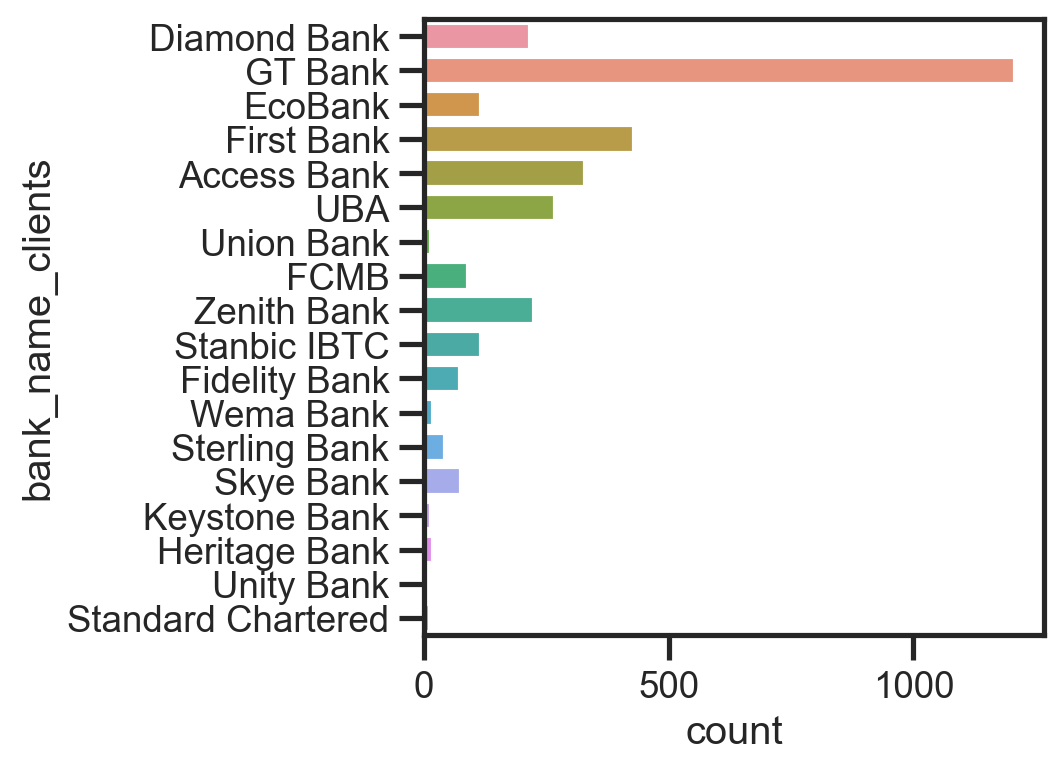

In [11]:
sns.countplot(y="bank_name_clients", data=train);

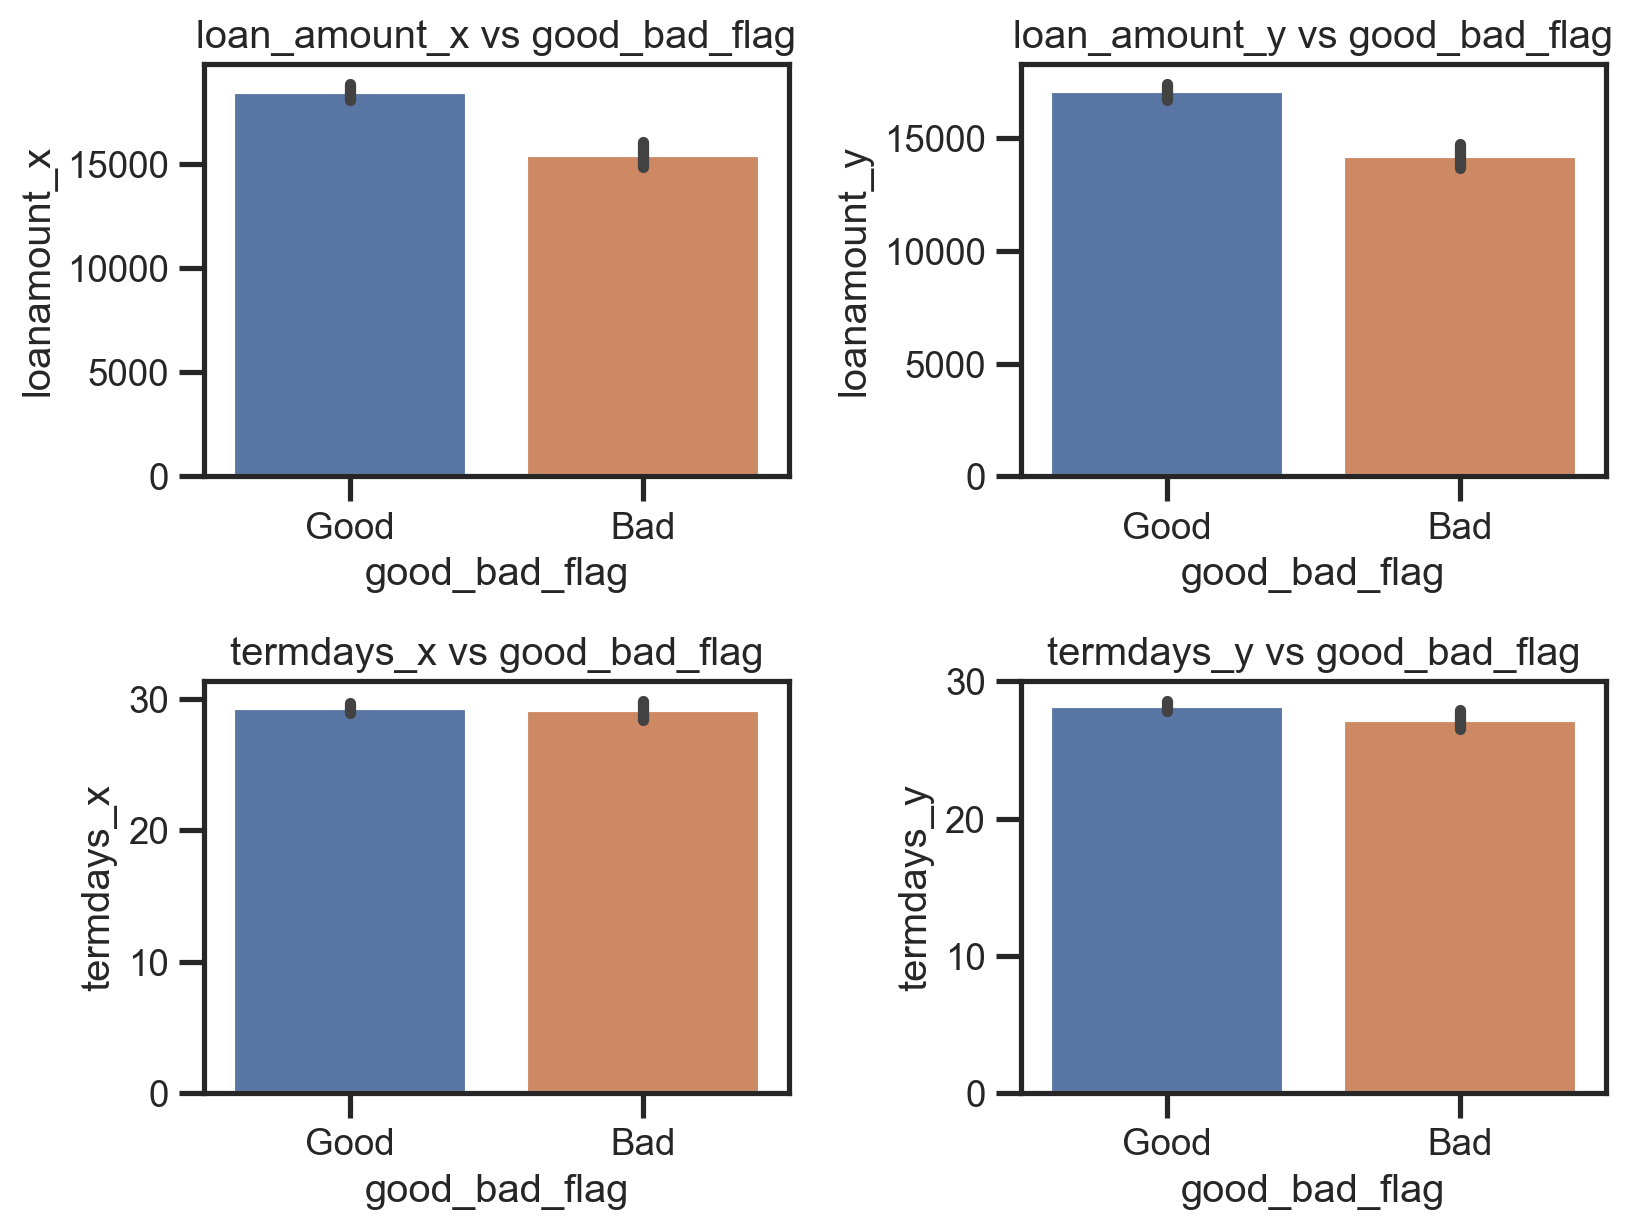

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(8,6))
fig.tight_layout(h_pad=3, w_pad=3)
sns.barplot(data=train, y='loanamount_x', x="good_bad_flag", ax = ax[0,0])
sns.barplot(data=train, y='loanamount_y', x="good_bad_flag", ax = ax[0,1])
sns.barplot(data=train, y='termdays_x', x="good_bad_flag", ax = ax[1,0])
sns.barplot(data=train, y='termdays_y', x="good_bad_flag", ax = ax[1,1])

#define subplot titles
ax[0, 0].set_title('loan_amount_x vs good_bad_flag')
ax[0, 1].set_title('loan_amount_y vs good_bad_flag')
ax[1, 0].set_title('termdays_x vs good_bad_flag')
ax[1, 1].set_title('termdays_y vs good_bad_flag')

plt.show()

###### convert date columns to a pandas datetime

In [13]:
cols = ["birthdate", "approveddate_y", "approveddate_x","firstduedate","firstrepaiddate","creationdate_y",
       "creationdate_x","closeddate"]

In [14]:
def convert_dates(series):
    return pd.to_datetime(series, errors='coerce')

In [15]:
## covert dates to pandas datetime

for col in cols:
    train[col] = convert_dates(train[col])
    test[col] = convert_dates(test[col])

In [16]:
len(train)

4368

In [17]:
## check for missing values
train.isnull().sum()

customerid                       0
systemloanid_x                   0
loannumber_x                     0
approveddate_x                   0
creationdate_x                   0
loanamount_x                     0
totaldue_x                       0
termdays_x                       0
referredby                    3781
good_bad_flag                    0
systemloanid_y                   9
loannumber_y                     9
approveddate_y                   9
creationdate_y                   9
loanamount_y                     9
totaldue_y                       9
termdays_y                       9
closeddate                       9
firstduedate                     9
firstrepaiddate                  9
birthdate                     1099
bank_account_type             1099
longitude_gps                 1099
latitude_gps                  1099
bank_name_clients             1099
bank_branch_clients           4335
employment_status_clients     1592
level_of_education_clients    3925
dtype: int64

In [18]:
train.head()

,customerid,systemloanid_x,loannumber_x,approveddate_x,creationdate_x,loanamount_x,totaldue_x,termdays_x,referredby,good_bad_flag,...,firstduedate,firstrepaiddate,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,NaN,Good,...,2017-07-31,2017-07-25 08:04:27,1972-01-15,Other,3.432010,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,NaN,Good,...,NaT,NaT,1985-08-23,Savings,3.885298,7.320700,GT Bank,"DUGBE,IBADAN",Permanent,Graduate
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,NaN,Good,...,2017-05-26,2017-05-26 04:07:34,1984-09-18,Other,11.139350,10.292041,EcoBank,NaN,Permanent,NaN
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.0,11500.0,15,NaN,Good,...,2017-07-03,2017-07-14 21:08:35,1977-10-10,Savings,3.985770,7.491708,First Bank,NaN,Permanent,NaN
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.0,44000.0,30,NaN,Good,...,2017-07-04,2017-07-03 23:25:29,1986-09-07,Other,7.457913,9.076574,GT Bank,NaN,Permanent,Primary


In [19]:
## feature engineering and fill in missing values
customerid = test['customerid']

def feat_eng(data):
    ## fill in missing values
    data.employment_status_clients = data.employment_status_clients.fillna('noinfo')
    data.loannumber_y = data.loannumber_y.fillna(data.loannumber_x - 1)
    data.totaldue_y = data.totaldue_y.fillna(data.loanamount_y + (data.loanamount_y * (data.termdays_y/100)))
    
    ## add new features
    #data["age_of_applicant"] = data.approveddate_x.dt.year - data.birthdate.dt.year
    data["tenure"] = (data.closeddate - data.approveddate_y).dt.total_seconds() / (24 * 60 * 60)
    data["default_on_file"] = (data.termdays_y - data.tenure).apply(lambda x: 0 if x >= 0 else 1)

    
    ## drop columns with a lot of missing values. We will also drop customerid and systemloanid
    data.drop(labels=["bank_branch_clients","level_of_education_clients","referredby","customerid",
                     "systemloanid_x", "systemloanid_y","approveddate_x","creationdate_x","approveddate_y","creationdate_y",
                     "closeddate","firstduedate","firstrepaiddate","birthdate","totaldue_x","totaldue_y",
                     "loannumber_y","loannumber_x"], 
              axis=1,inplace=True)
    
    return data
    
train = feat_eng(train)
test = feat_eng(test)

In [20]:
## map our target values to 0 or 1
train.good_bad_flag = train.good_bad_flag.map({'Good': 1, 'Bad':0})

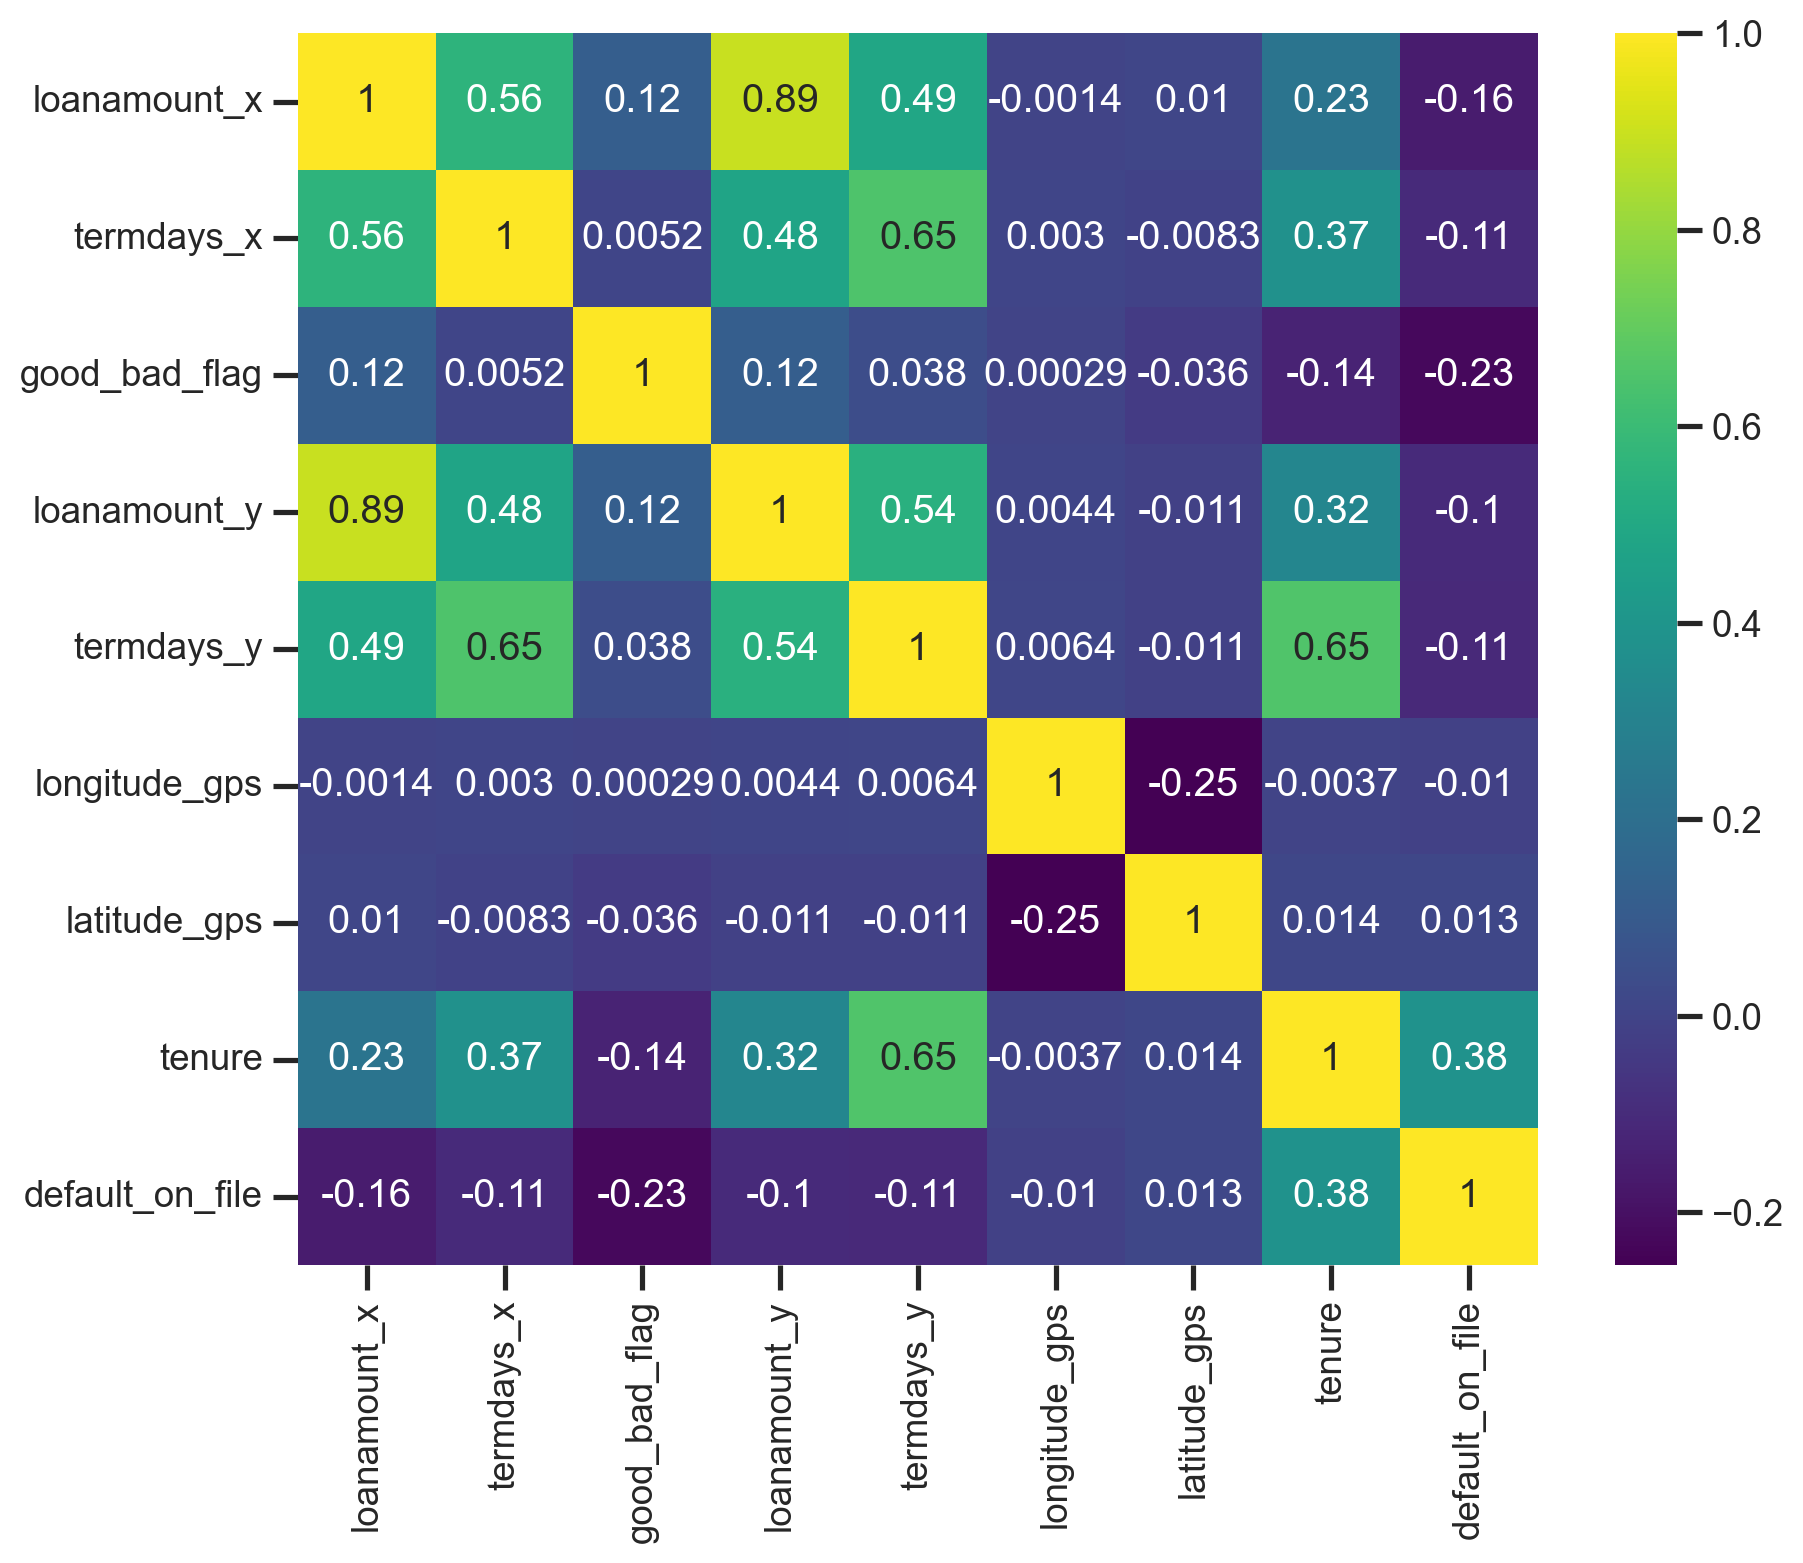

In [21]:
fig = plt.figure(figsize=(10,8))
corr = train.corr()
sns.heatmap(corr, cmap="viridis", annot=True);

In [22]:
X = train.drop(labels=["good_bad_flag"], axis=1)
y = train["good_bad_flag"]

##### Create a data pipeline. Separate the dataset into numeric and categorical features and perform different operations on them

In [23]:
numeric_features = X.select_dtypes(exclude="object").columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

In [24]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", StandardScaler())
    ]
).set_output(transform='pandas')

In [25]:
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')),
    ]
).set_output(transform='pandas')

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [27]:
### split our dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
### Build our model using a pipeline. 

model = Pipeline( 
    steps=[ ("preprocessor", preprocessor),
           ('over', SMOTE(k_neighbors=3)),          ## smote oversampler to oversample the minority class
           ("xgb", XGBClassifier())])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loanamount_x', 'termdays_x',
                                                   'loanamount_y', 'termdays_y',
                                                   'longitude_gps',
                                                   'latitude_gps', 'tenure',
                                                   'default_on_file']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [29]:
scores = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
print(f"Cross_val_score Accuracy: {scores.mean()}")
print(f"Standard deviation of the scores: {scores.std()}")

Cross_val_score Accuracy: 0.7002627257799673
Standard deviation of the scores: 0.027326133507739755


#### GRID SEARCH

In [30]:
parameters = {
    "n_estimators": [50,100,150],
    "max_depth": [2,5,8,12,15],
    "subsample": [0.7,0.8,0.9]
}

In [31]:
gridsearch = GridSearchCV(XGBClassifier(), param_grid=parameters, scoring="accuracy",
                          n_jobs=-1, verbose=1)

In [32]:
grid = Pipeline( 
    steps=[ ("preprocessor", preprocessor), 
           ("gridsearch", gridsearch)])

In [33]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loanamount_x', 'termdays_x',
                                                   'loanamount_y', 'termdays_y',
                                                   'longitude_gps',
                                                   'latitude_gps', 'tenure',
                                                   'default_on_file']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...),
                              n_jobs=-1,
                              param_grid={'max_depth': [2, 5, 8, 12, 15],
                                          'n_estimators': [50, 100, 150],
                                          'subsample': [0.7, 0.8, 0.9]},
                              scoring='accuracy', verbose=1))])

In [34]:
print(grid.named_steps["gridsearch"].best_estimator_) 
print(grid.named_steps["gridsearch"].best_params_)
print(grid.named_steps["gridsearch"].best_score_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
{'max_depth': 2, 'n_estimators': 50, 'subsample': 0.9}
0.7993728248705684


In [35]:
model = Pipeline( 
    steps=[ ("preprocessor", preprocessor), 
           ("xgb", XGBClassifier(max_depth=2,
                                n_estimators=50,
                                subsample=0.9))])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loanamount_x', 'termdays_x',
                                                   'loanamount_y', 'termdays_y',
                                                   'longitude_gps',
                                                   'latitude_gps', 'tenure',
                                                   'default_on_file']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [36]:
scores = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
print(f"Cross_val_score Accuracy: {scores.mean()}")
print(f"Standard deviation of the scores: {scores.std()}")

Cross_val_score Accuracy: 0.758607553366174
Standard deviation of the scores: 0.01860501102149403


#### ANALYSIS OF RESULTS

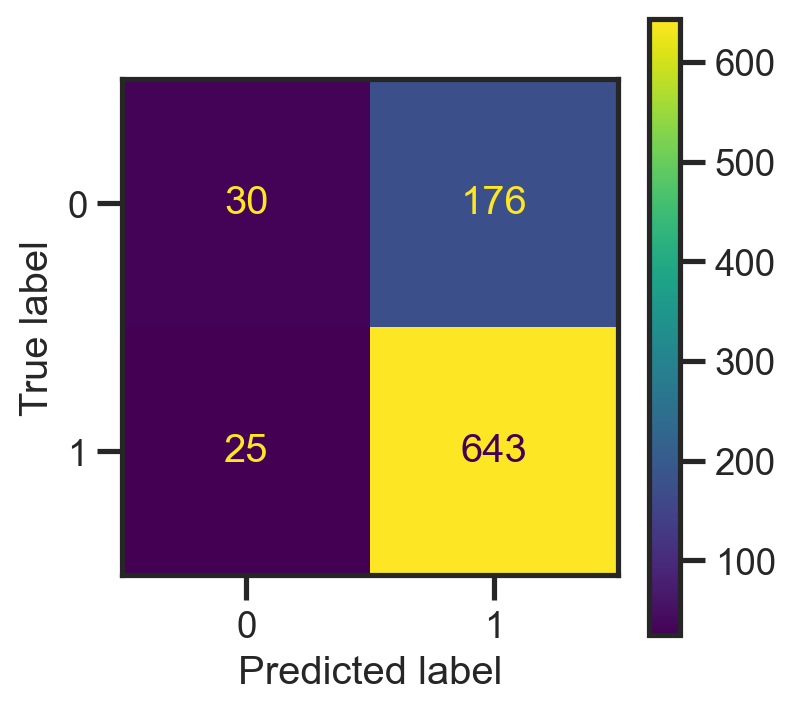

In [37]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()

plt.grid(False)
plt.show()

In [38]:
classreport = classification_report(y_test, predictions)
print(classreport)

              precision    recall  f1-score   support

           0       0.55      0.15      0.23       206
           1       0.79      0.96      0.86       668

    accuracy                           0.77       874
   macro avg       0.67      0.55      0.55       874
weighted avg       0.73      0.77      0.72       874

